## Import Package

307
0
                  Category  Rating  Reviews    Size  Installs  Type  Price  \
0           ART_AND_DESIGN     4.1      159  19.000     10000  Free    0.0   
1           ART_AND_DESIGN     3.9      967  14.000    500000  Free    0.0   
2           ART_AND_DESIGN     4.7    87510   8.700   5000000  Free    0.0   
3           ART_AND_DESIGN     4.5   215644  25.000  50000000  Free    0.0   
4           ART_AND_DESIGN     4.3      967   2.800    100000  Free    0.0   
...                    ...     ...      ...     ...       ...   ...    ...   
10833  BOOKS_AND_REFERENCE     4.8       44   0.619      1000  Free    0.0   
10834               FAMILY     4.0        7   2.600       500  Free    0.0   
10836               FAMILY     4.5       38  53.000      5000  Free    0.0   
10837               FAMILY     5.0        4   3.600       100  Free    0.0   
10840            LIFESTYLE     4.5   398307  19.000  10000000  Free    0.0   

      Content Rating                     Genres  days_sin

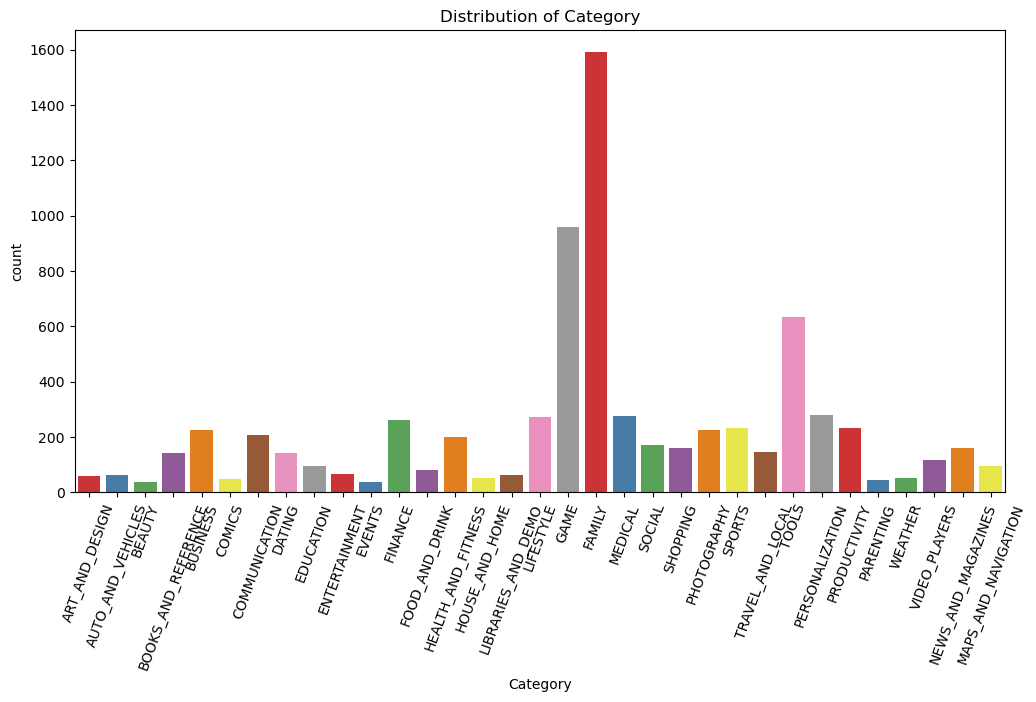

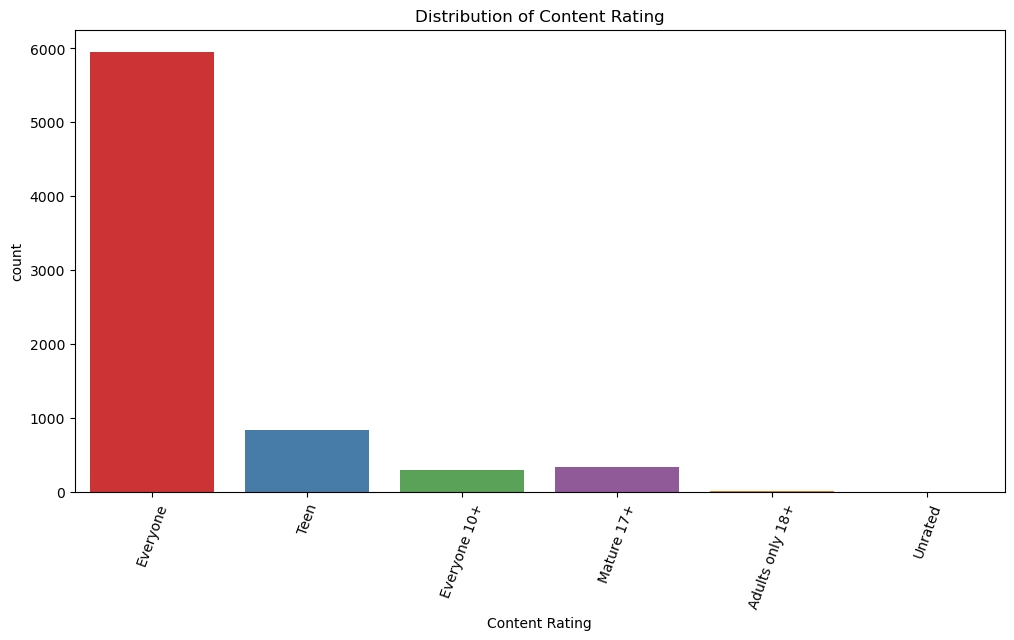

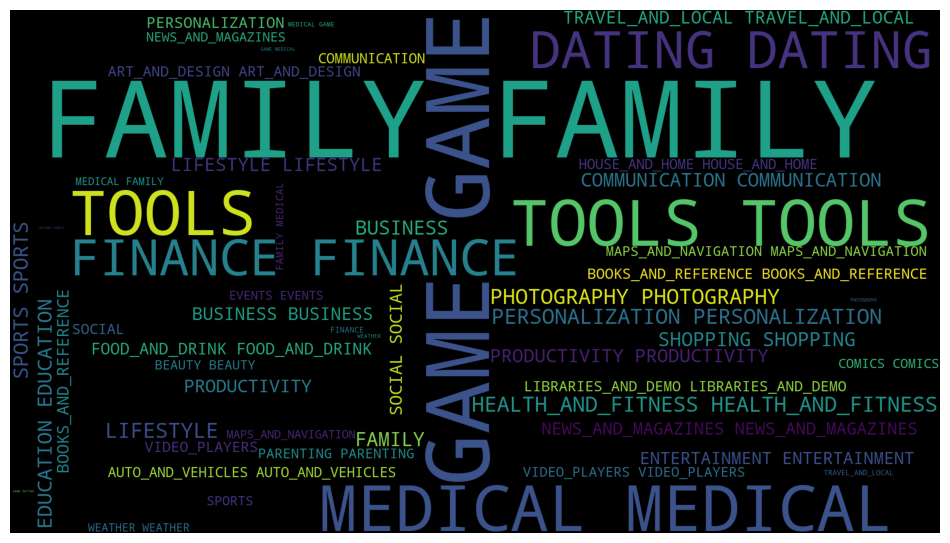

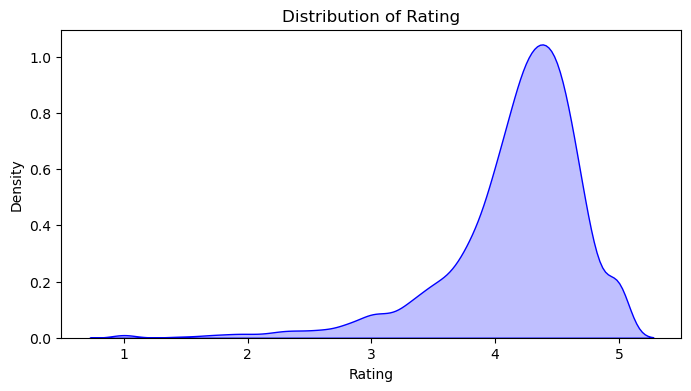

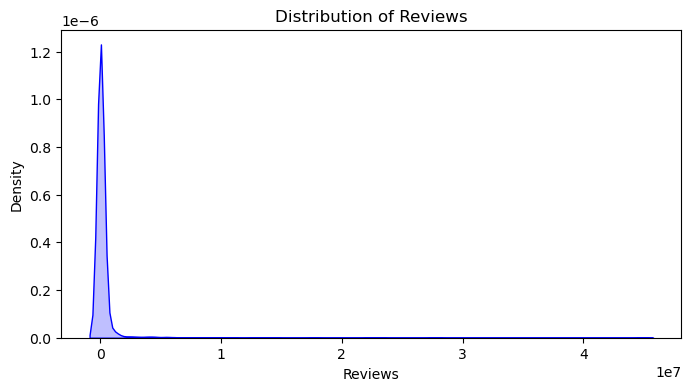

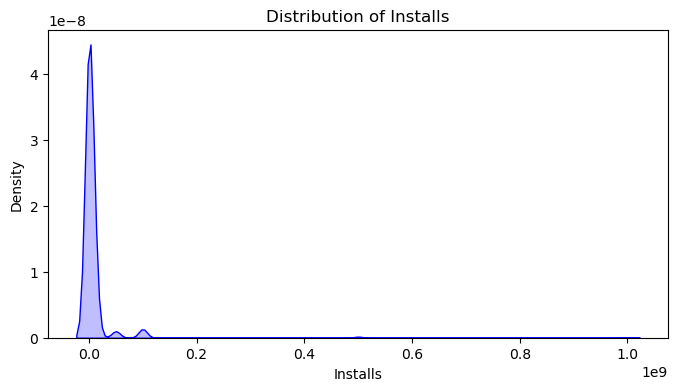

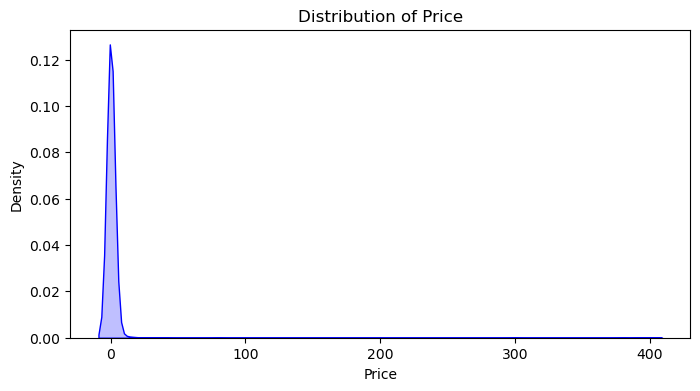

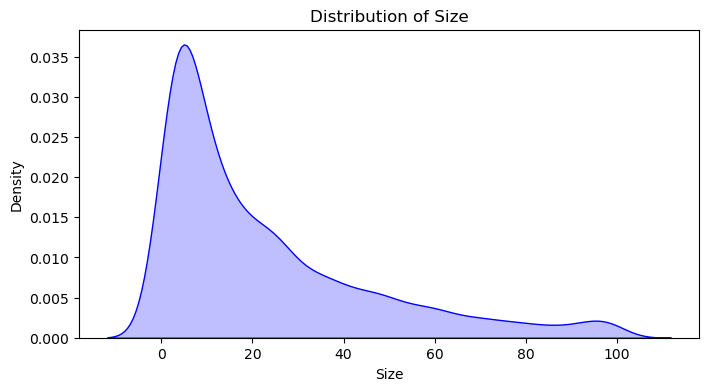

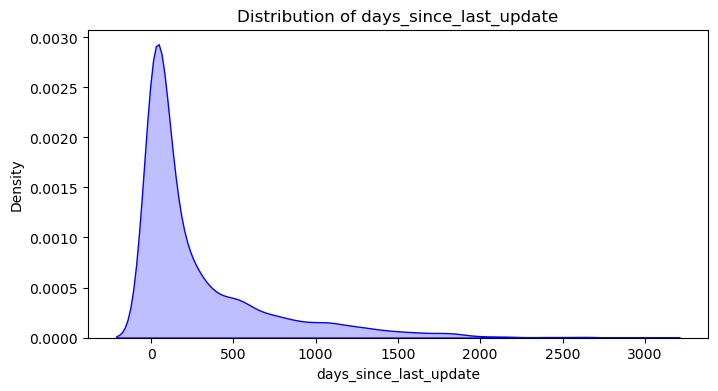

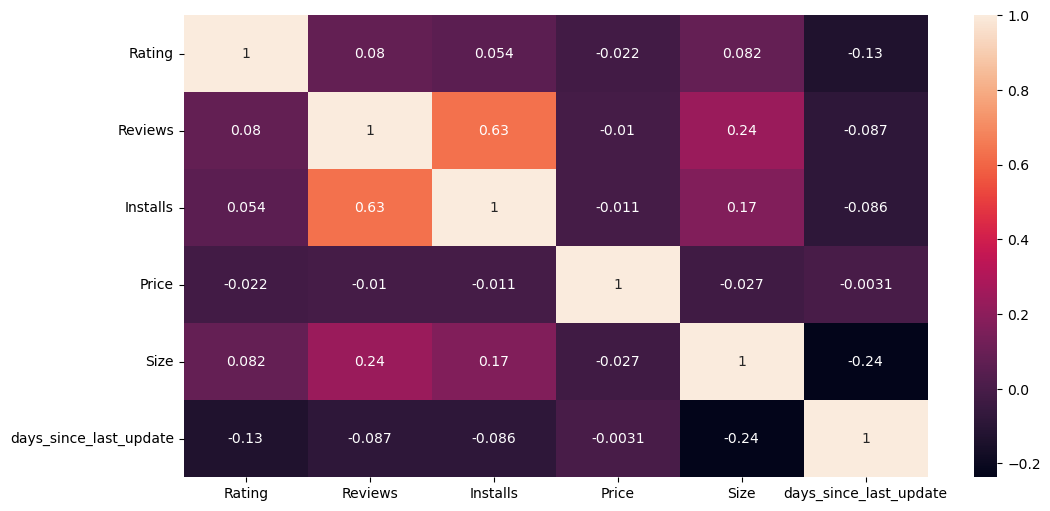

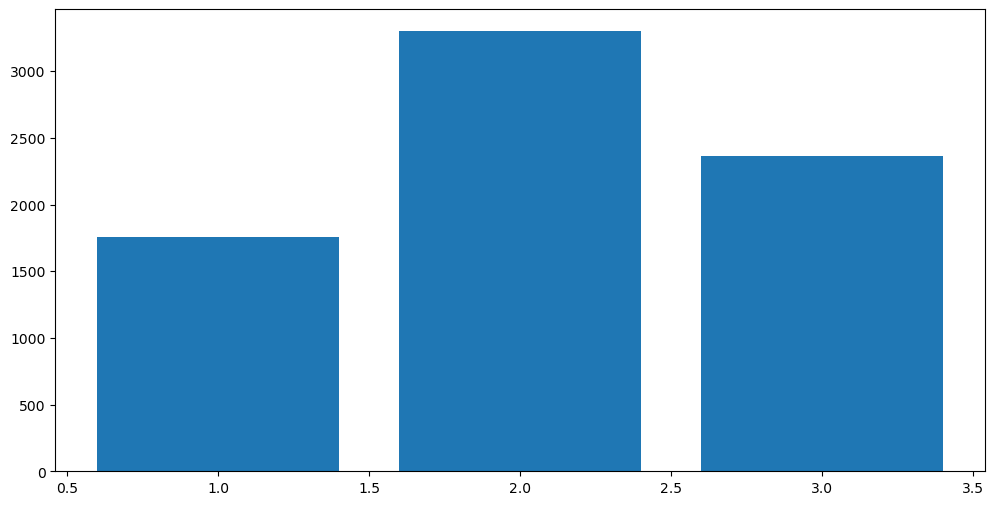

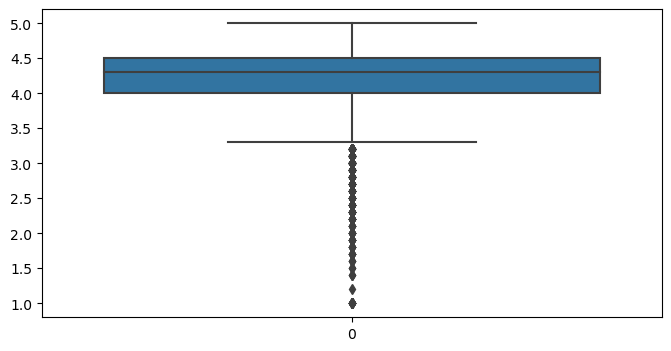

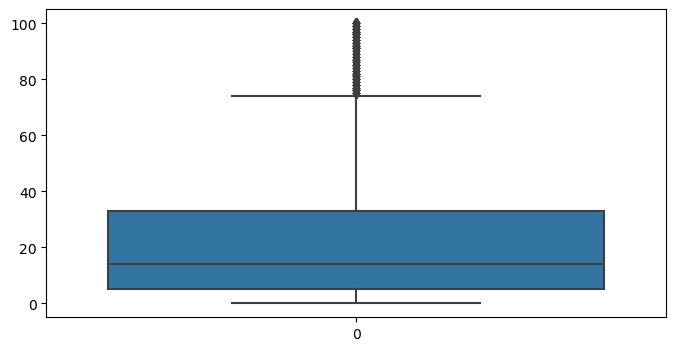

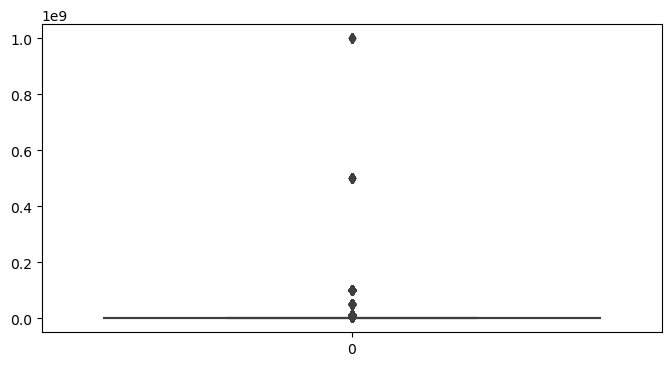

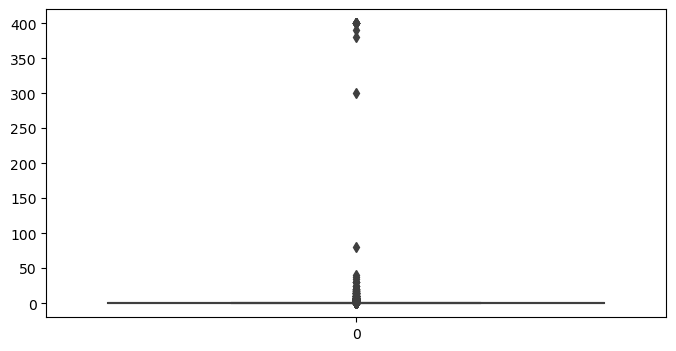

In [11]:
%run ./ESE527_project_setup.ipynb

# Predictive Analysis

### Remove outlier by using DB-scan

### Split dataset

In [12]:
features=data_db.drop(['Rating', 'Rating Interval'],axis=1)
label=data_db['Rating Interval']
standardized_features=Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
smote = SMOTE()
# Fit and apply SMOTE
train_X, train_Y = smote.fit_resample(train_X, train_Y)

In [13]:
lasso = Lasso(alpha=0.01)
# Fit Lasso model on the training data
lasso.fit(train_X, train_Y)
# Get the coefficients
coefficients = pd.Series(lasso.coef_, index=train_X.columns)
# Filter features with non-zero coefficients
selected_features = coefficients[coefficients != 0].index.tolist()
print('Selected features:', selected_features)
print('Number of selected features:', len(selected_features))
train_X=train_X[selected_features]
test_X=test_X[selected_features]

Selected features: ['Reviews', 'Price', 'days_since_last_update', 'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES', 'Category_BOOKS_AND_REFERENCE', 'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION', 'Category_EVENTS', 'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME', 'Category_HEALTH_AND_FITNESS', 'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL', 'Category_PERSONALIZATION', 'Category_SHOPPING', 'Category_TOOLS', 'Category_VIDEO_PLAYERS', 'Content Rating_Adults only 18+', 'Content Rating_Mature 17+', 'Content Rating_Teen', 'Genres_Adventure', 'Genres_Adventure;Action & Adventure', 'Genres_Arcade;Action & Adventure', 'Genres_Arcade;Pretend Play', 'Genres_Art & Design;Creativity', 'Genres_Art & Design;Pretend Play', 'Genres_Auto & Vehicles', 'Genres_Books & Reference', 'Genres_Casual', 'Genres_Casual;Brain Games', 'Genres_Comics', 'Genres_Communication', 'Genres_Dating', 'Genres_Education', 'Genres_Education;Education', 'Genres_

In [14]:
model = LogisticRegression(random_state=0)
# Define the grid of values for hyperparameters
params = {
    'C': [0.01,0.1,1,10,100,1000],
    'penalty': ['l2'],
    'solver': ['newton-cg','lbfgs','liblinear','sag']
}
train_X=train_X[selected_features]
test_X=test_X[selected_features]
# Define GridSearchCV
LR_clf = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1)
LR_clf.fit(train_X, train_Y)
# Best parameters and best score
print("Best parameters:", LR_clf.best_params_)
print("Best score:", LR_clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.47723302456257477


In [15]:
# Best model:
LR_clf.best_estimator_.score(test_X[selected_features],test_Y)

0.4451219512195122

Accuracy: 0.4451219512195122
Precision: 0.492874721699845
Recall: 0.4451219512195122
F1 Score: 0.44843135807411033


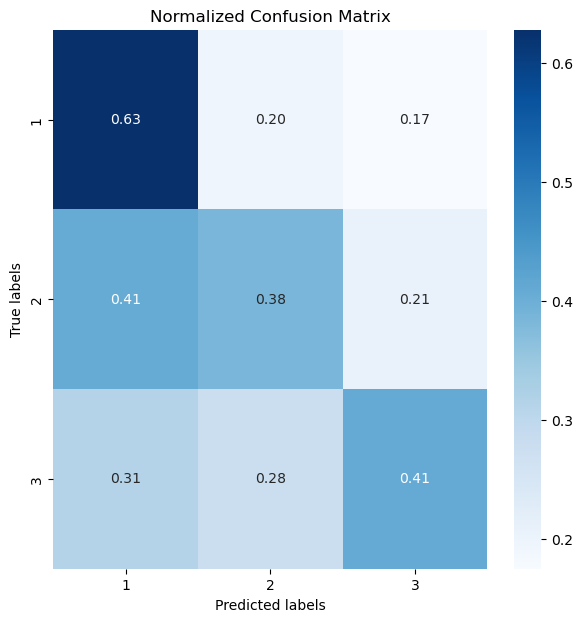

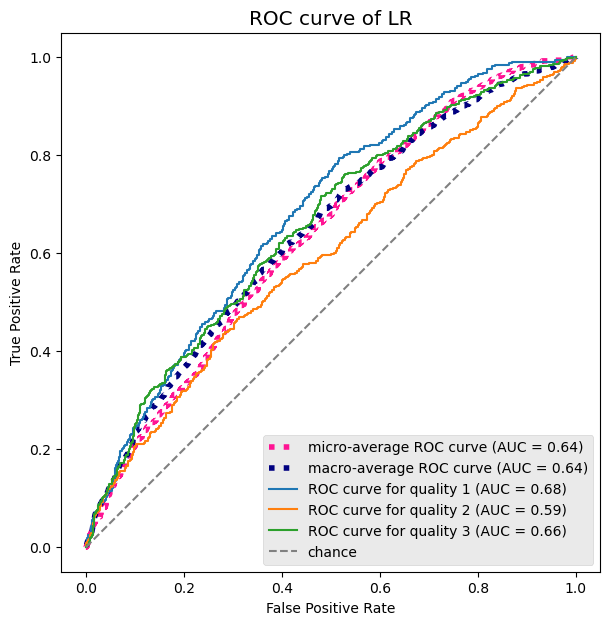

In [16]:
cm(test_X,test_Y,LR_clf)
ROC(train_Y,test_Y,LR_clf,'Logistic Regression',)

### Random Forest

In [17]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion',['gini', 'entropy']),
        'max_features': trial.suggest_int('max_features', 1, 10),
    }
    RF_clf = RandomForestClassifier(**params)
    RF_clf.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(RF_clf, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-04 18:53:24,985] A new study created in memory with name: no-name-00af9be1-dbc8-49a2-8e7b-6fba02c4424b


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-05-04 18:53:49,047] Trial 0 finished with value: 0.4978988748813881 and parameters: {'n_estimators': 714, 'criterion': 'entropy', 'max_features': 4}. Best is trial 0 with value: 0.4978988748813881.
[I 2024-05-04 18:53:56,668] Trial 1 finished with value: 0.4878676968957571 and parameters: {'n_estimators': 239, 'criterion': 'entropy', 'max_features': 1}. Best is trial 0 with value: 0.4978988748813881.
[I 2024-05-04 18:54:24,922] Trial 2 finished with value: 0.5056255930595093 and parameters: {'n_estimators': 874, 'criterion': 'gini', 'max_features': 7}. Best is trial 2 with value: 0.5056255930595093.
[I 2024-05-04 18:54:56,871] Trial 3 finished with value: 0.5077944964077538 and parameters: {'n_estimators': 838, 'criterion': 'entropy', 'max_features': 9}. Best is trial 3 with value: 0.5077944964077538.
[I 2024-05-04 18:55:27,978] Trial 4 finished with value: 0.5057611495187746 and parameters: {'n_estimators': 982, 'criterion': 'gini', 'max_features': 6}. Best is trial 3 with val

In [18]:
clf_RF= RandomForestClassifier(**best_params)
clf_RF.fit(train_X, train_Y)
y_pred=clf_RF.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

0.4911924119241192

Accuracy: 0.4911924119241192
Precision: 0.5064774450514489
Recall: 0.4911924119241192
F1 Score: 0.49576960956040517


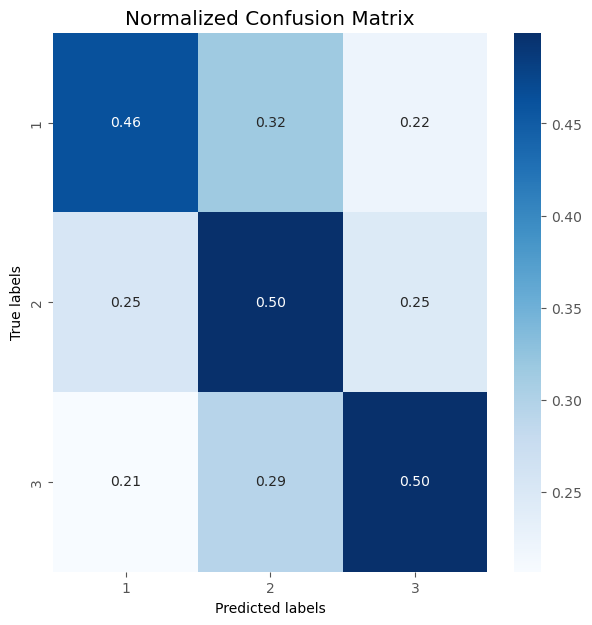

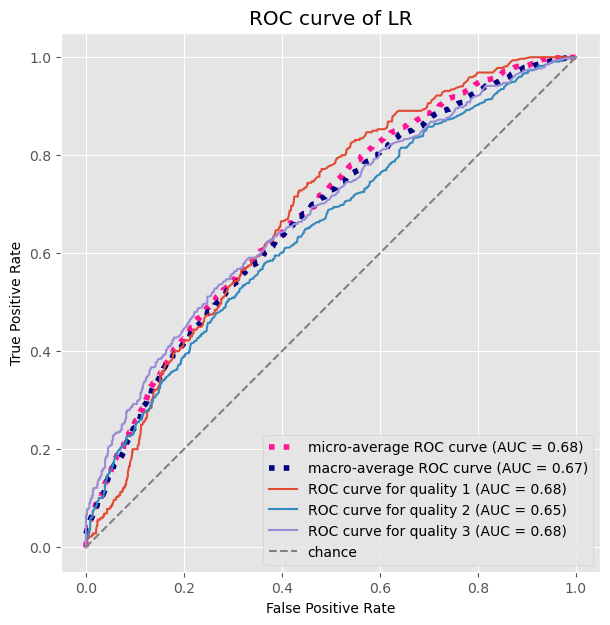

In [19]:
cm(test_X,test_Y,clf_RF)
ROC(train_Y,test_Y,clf_RF,'Random Forest')

### Lightgbm

In [20]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-05-04 18:55:40,829] A new study created in memory with name: no-name-3f8ee0ce-f6cb-40ff-bad6-9c3d1434791e


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8708797131664835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8708797131664835
[LightGBM] [Warning] bagging_fraction is set=0.6984763767348969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6984763767348969
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8708797131664835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8708797131664835
[LightGBM] [Warning] bagging_fraction is set=0.6984763767348969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6984763767348969
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds

In [21]:
clf_lgbm= lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred=clf_lgbm.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred)
accuracy

[LightGBM] [Warning] feature_fraction is set=0.8249269297599247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8249269297599247
[LightGBM] [Warning] bagging_fraction is set=0.8261265150031347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8261265150031347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8249269297599247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8249269297599247
[LightGBM] [Warning] bagging_fraction is set=0.8261265150031347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8261265150031347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds

0.4708672086720867

In [23]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) days_since_last_update         8062.000000
 2) Reviews                        7563.000000
 3) Price                          899.000000
 4) Content Rating_Teen            581.000000
 5) Category_GAME                  473.000000
 6) Genres_Entertainment           449.000000
 7) Category_TOOLS                 421.000000
 8) Genres_Education               309.000000
 9) Content Rating_Mature 17+      304.000000
10) Category_PERSONALIZATION       301.000000
11) Category_LIFESTYLE             265.000000
12) Category_MEDICAL               261.000000
13) Category_HEALTH_AND_FITNESS    230.000000
14) Category_COMMUNICATION         225.000000
15) Type_Free                      218.000000
16) Genres_Casual                  214.000000
17) Category_FINANCE               210.000000
18) Category_BOOKS_AND_REFERENCE   200.000000
19) Category_VIDEO_PLAYERS         180.000000
20) Category_SHOPPING              180.000000
21) Genres_Travel & Local          164.000000
22) Category_MAPS_AND_NAVIGATION

[LightGBM] [Warning] feature_fraction is set=0.8249269297599247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8249269297599247
[LightGBM] [Warning] bagging_fraction is set=0.8261265150031347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8261265150031347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Accuracy: 0.4708672086720867
Precision: 0.4993719595023029
Recall: 0.4708672086720867
F1 Score: 0.4758122800489233


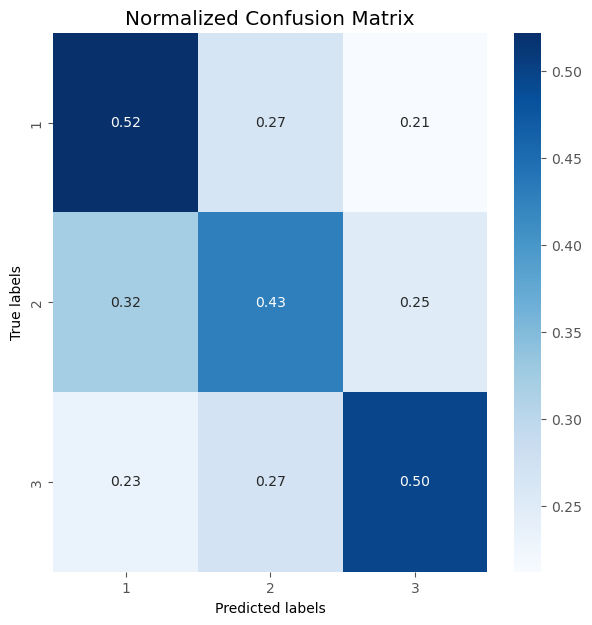

[LightGBM] [Warning] feature_fraction is set=0.8249269297599247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8249269297599247
[LightGBM] [Warning] bagging_fraction is set=0.8261265150031347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8261265150031347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


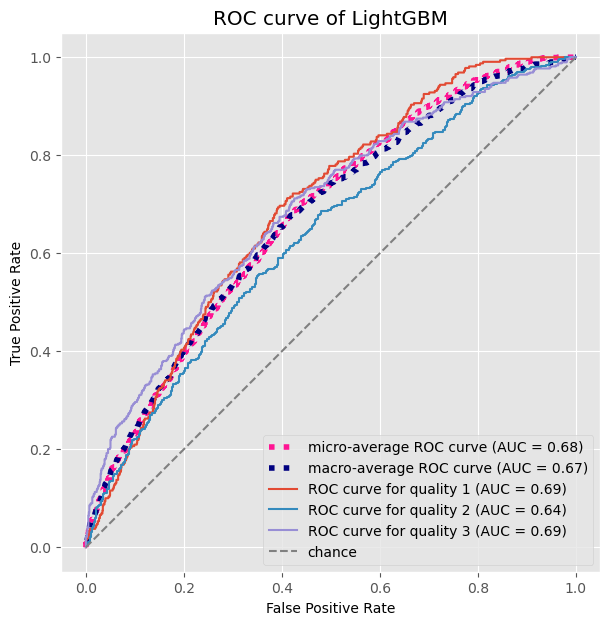

In [24]:
cm(test_X,test_Y,clf_lgbm)
ROC(train_Y,test_Y,clf_lgbm,'LightGBM')